In [ ]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, ViTForImageClassification
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # Untuk progress bar

# Load model dan processor
image_processor = AutoImageProcessor.from_pretrained("chexpert-vit-model")
model = ViTForImageClassification.from_pretrained("chexpert-vit-model")
# model.eval()



In [206]:
from torch.utils.data import Dataset

label_cols = [
    'Enlarged Cardiomediastinum', 
    'Cardiomegaly',
    'Lung Opacity', 
    'Lung Lesion', 
    'Edema', 
    'Consolidation',
    'Pneumonia',
    'Atelectasis', 
    'Pneumothorax', 
    'Pleural Effusion',
    # 'Pleural Other',
    'Fracture',
    # 'Support Devices'
]

label2id = {label: i for i, label in enumerate(label_cols)}
id2label = {i: label for label, i in label2id.items()}

class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform, label2id):
        # dataframe: list of dict {'Path': ..., 'Labels': [...]}
        self.data = list(dataframe)
        self.transform = transform
        self.label2id = label2id

    def __len__(self):
        # Mengembalikan jumlah data
        return len(self.data)

    def __getitem__(self, idx):
        # Ambil path gambar dan label
        image_path = self.data[idx]['Path']
        findings = self.data[idx]['Labels']
        image = Image.open(image_path).convert("RGB")

        # Membuat vektor biner multilabel
        label_vec = torch.zeros(len(self.label2id))
        for finding in findings:
            if finding in self.label2id:
                label_vec[self.label2id[finding]] = 1.0

        # Transformasi gambar jika ada
        if self.transform:
            image = self.transform(image)

        # Kembalikan dictionary sesuai kebutuhan Trainer HuggingFace
        return {"Path": image, "Labels": label_vec}



In [207]:
def create_label_dataset(df):
    label_columns_temp = df.columns[1:]  # kolom label (kecuali 'Path')
    df2 = []  # list untuk menyimpan data baru
    for idx, row in df.iterrows():
        labels = [col for col in label_columns_temp if row[col] == 1.0]
        df2.append({'Path': row['Path'], 'Labels': labels})

    # Konversi df2 ke DataFrame agar berbentuk tabel
    # df2 = pd.DataFrame(df2, columns=['Path', 'Labels'])
    return df2

df_test = pd.read_csv('df_test.csv')
df_test = create_label_dataset(df_test)

df_val = pd.read_csv('df_val.csv')
df_val = create_label_dataset(df_val)

In [208]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

dataset_test = CheXpertDataset(df_val, transform, label2id)

In [209]:
# Inisialisasi tempat penyimpanan hasil
all_probabilities = []
all_true_labels = []

# Loop melalui semua data test
for idx in tqdm(range(len(df_val)), desc="Processing Test Data"):
    image_test = Image.open(df_val[idx]['Path']).convert("RGB")
    y_actual = dataset_test[idx]['Labels']

    inputs = image_processor(image_test, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    probabilities = torch.sigmoid(probabilities)

    # Simpan hasil
    all_probabilities.append(probabilities)
    all_true_labels.append(y_actual)

import torch
from torch.nn.functional import sigmoid

# Setelah loop selesai, gabungkan semua tensor 1D menjadi tensor 2D
all_true_labels = torch.stack(all_true_labels)  # Shape: (n_samples, n_labels)
all_probabilities = torch.stack(all_probabilities)  # Shape: (n_samples, n_labels)


Processing Test Data: 100%|██████████| 187/187 [00:19<00:00,  9.53it/s]


In [210]:
auc_acuration = roc_auc_score(all_true_labels, all_probabilities, average=None)
auc_acuration

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


array([0.19076675, 0.55775978, 0.59419787, 0.39247312, 0.787005  ,
       0.1900463 , 0.32539683, 0.40534826, 0.68253968, 0.89527665,
              nan])

In [211]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, roc_curve

def find_optimal_thresholds(all_true_labels, all_probabilities, id2label):
    """
    Mencari threshold optimal untuk setiap label berdasarkan F1-score maksimal
    dan menampilkannya dengan nama label.
    
    Args:
        all_true_labels: Tensor 2D (n_samples, n_labels) berisi label benar
        all_probabilities: Tensor 2D (n_samples, n_labels) berisi probabilitas prediksi
        id2label: Dictionary mapping id label ke nama label (dari model.config.id2label)
    
    Returns:
        Dict berisi nama label dan threshold optimalnya
    """
    optimal_thresholds = {}
    n_labels = all_true_labels.shape[1]
    
    for i in range(n_labels):
        label_name = id2label[i]  # Dapatkan nama label dari id2label
        y_true = all_true_labels[:, i].cpu().numpy()
        y_score = all_probabilities[:, i].cpu().numpy()
        
        # Cek jika label memiliki kedua kelas (0 dan 1)
        if len(np.unique(y_true)) < 2:
            print(f"Label '{label_name}' diabaikan karena hanya memiliki satu kelas.")
            optimal_thresholds[label_name] = np.nan
            continue
        
        try:
            # Hitung precision-recall curve
            precision, recall, thresholds = precision_recall_curve(y_true, y_score)
            
            # Hitung F1-score untuk setiap threshold
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
            
            # Ambil threshold dengan F1-score maksimal
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            
            # Simpan dengan nama label
            optimal_thresholds[label_name] = optimal_threshold
            
            # (Opsional) Hitung AUC untuk referensi
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = np.trapz(tpr, fpr)
            
            print(f"Label '{label_name}':")
            print(f"  Optimal Threshold = {optimal_threshold:.4f}")
            print(f"  AUC = {auc_score:.4f}")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error pada label '{label_name}': {str(e)}")
            optimal_thresholds[label_name] = np.nan
    
    return optimal_thresholds

# Contoh Penggunaan
optimal_thresholds = find_optimal_thresholds(
    all_true_labels=all_true_labels,
    all_probabilities=all_probabilities,
    id2label=model.config.id2label  # Pastikan model memiliki atribut ini
)

# Hasil akhir dalam format dictionary
print("\nHasil Threshold Optimal:")
for label_name, threshold in optimal_thresholds.items():
    print(f"{label_name}: {threshold:.4f}")

Label 'Enlarged Cardiomediastinum':
  Optimal Threshold = 0.5021
  AUC = 0.1908
--------------------------------------------------
Label 'Cardiomegaly':
  Optimal Threshold = 0.5031
  AUC = 0.5578
--------------------------------------------------
Label 'Lung Opacity':
  Optimal Threshold = 0.5287
  AUC = 0.5942
--------------------------------------------------
Label 'Lung Lesion':
  Optimal Threshold = 0.5031
  AUC = 0.3925
--------------------------------------------------
Label 'Edema':
  Optimal Threshold = 0.5274
  AUC = 0.7870
--------------------------------------------------
Label 'Consolidation':
  Optimal Threshold = 0.5064
  AUC = 0.1900
--------------------------------------------------
Label 'Pneumonia':
  Optimal Threshold = 0.5023
  AUC = 0.3254
--------------------------------------------------
Label 'Atelectasis':
  Optimal Threshold = 0.5074
  AUC = 0.4053
--------------------------------------------------
Label 'Pneumothorax':
  Optimal Threshold = 0.5253
  AUC = 0.

/tmp/ipykernel_76784/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_76784/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_76784/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_76784/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_76784/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integ


ANALISIS UNTUK LABEL: ENLARGED CARDIOMEDIASTINUM


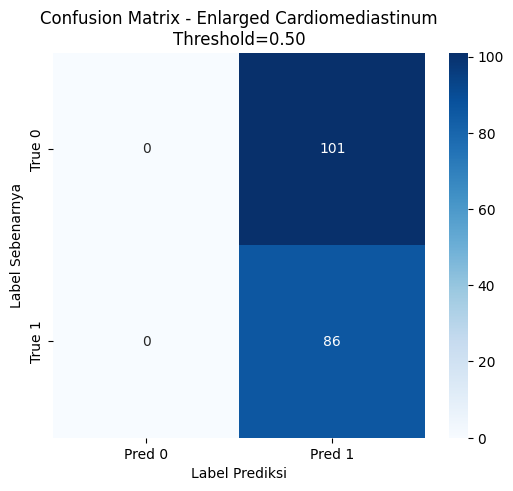

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       101
     Positif       0.46      1.00      0.63        86

    accuracy                           0.46       187
   macro avg       0.23      0.50      0.32       187
weighted avg       0.21      0.46      0.29       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.4599
- F1-Score: 0.6300

ANALISIS UNTUK LABEL: CARDIOMEGALY


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


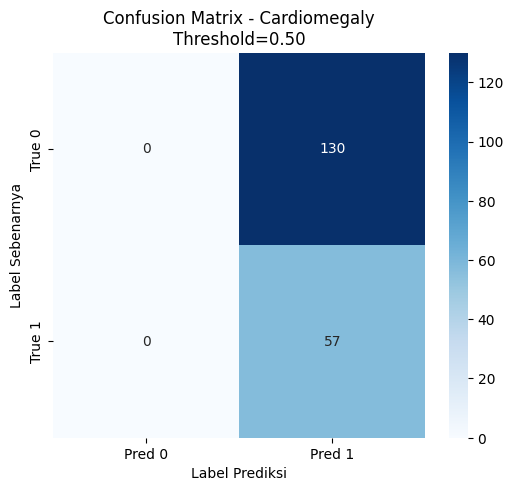

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       130
     Positif       0.30      1.00      0.47        57

    accuracy                           0.30       187
   macro avg       0.15      0.50      0.23       187
weighted avg       0.09      0.30      0.14       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.3048
- F1-Score: 0.4672

ANALISIS UNTUK LABEL: LUNG OPACITY


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


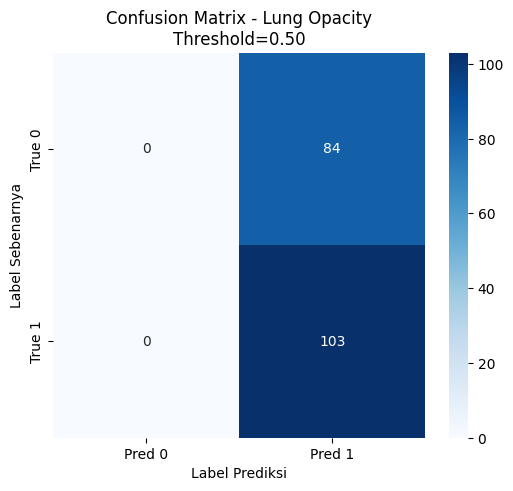

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        84
     Positif       0.55      1.00      0.71       103

    accuracy                           0.55       187
   macro avg       0.28      0.50      0.36       187
weighted avg       0.30      0.55      0.39       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.5508
- F1-Score: 0.7103

ANALISIS UNTUK LABEL: LUNG LESION


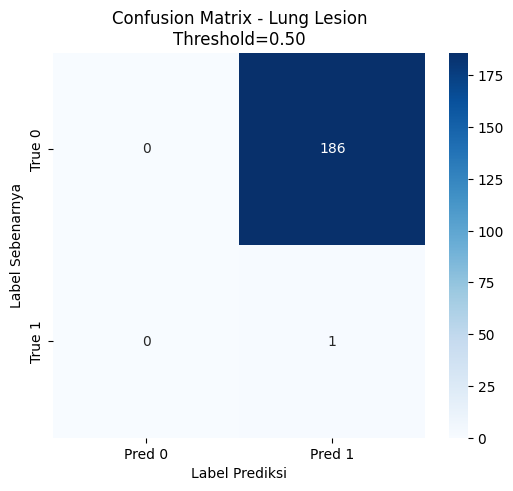

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       186
     Positif       0.01      1.00      0.01         1

    accuracy                           0.01       187
   macro avg       0.00      0.50      0.01       187
weighted avg       0.00      0.01      0.00       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.0053
- F1-Score: 0.0106

ANALISIS UNTUK LABEL: EDEMA


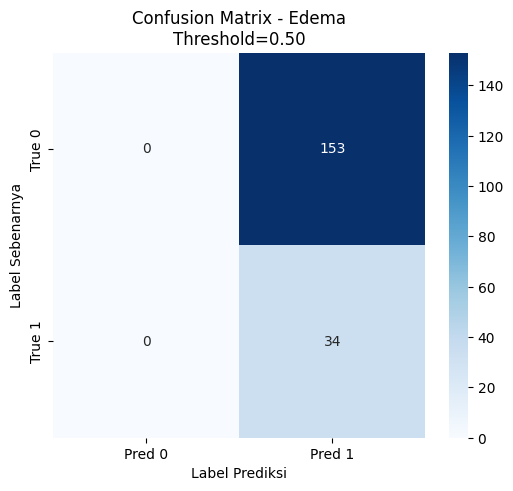

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       153
     Positif       0.18      1.00      0.31        34

    accuracy                           0.18       187
   macro avg       0.09      0.50      0.15       187
weighted avg       0.03      0.18      0.06       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.1818
- F1-Score: 0.3077

ANALISIS UNTUK LABEL: CONSOLIDATION


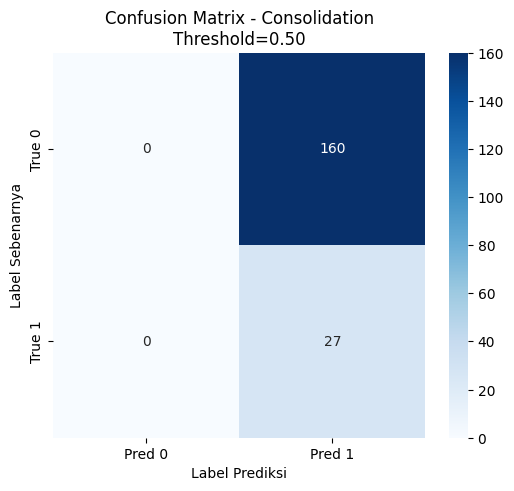

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       160
     Positif       0.14      1.00      0.25        27

    accuracy                           0.14       187
   macro avg       0.07      0.50      0.13       187
weighted avg       0.02      0.14      0.04       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.1444
- F1-Score: 0.2523

ANALISIS UNTUK LABEL: PNEUMONIA


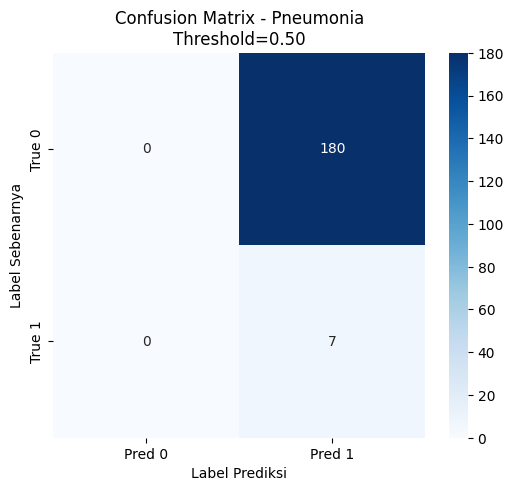

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       180
     Positif       0.04      1.00      0.07         7

    accuracy                           0.04       187
   macro avg       0.02      0.50      0.04       187
weighted avg       0.00      0.04      0.00       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.0374
- F1-Score: 0.0722

ANALISIS UNTUK LABEL: ATELECTASIS


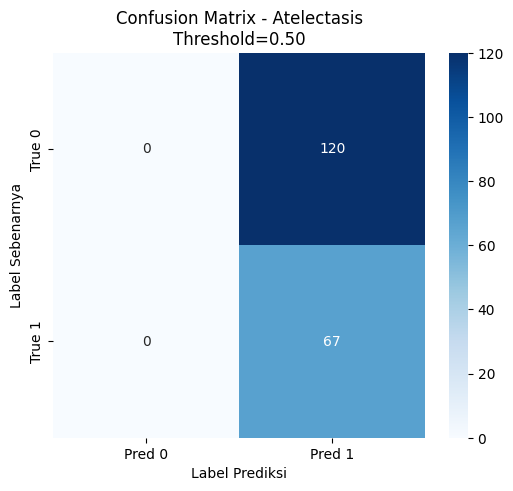

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       120
     Positif       0.36      1.00      0.53        67

    accuracy                           0.36       187
   macro avg       0.18      0.50      0.26       187
weighted avg       0.13      0.36      0.19       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.3583
- F1-Score: 0.5276

ANALISIS UNTUK LABEL: PNEUMOTHORAX


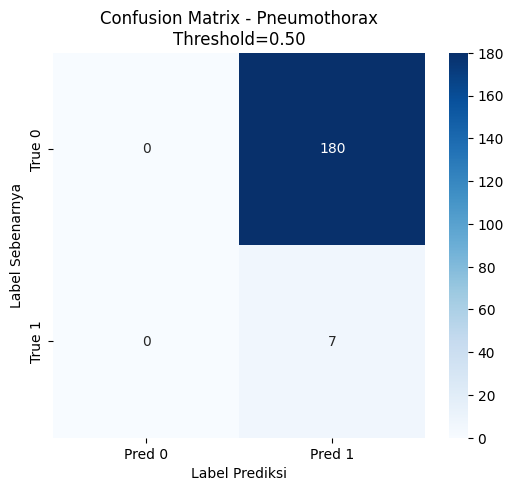

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       180
     Positif       0.04      1.00      0.07         7

    accuracy                           0.04       187
   macro avg       0.02      0.50      0.04       187
weighted avg       0.00      0.04      0.00       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.0374
- F1-Score: 0.0722

ANALISIS UNTUK LABEL: PLEURAL EFFUSION


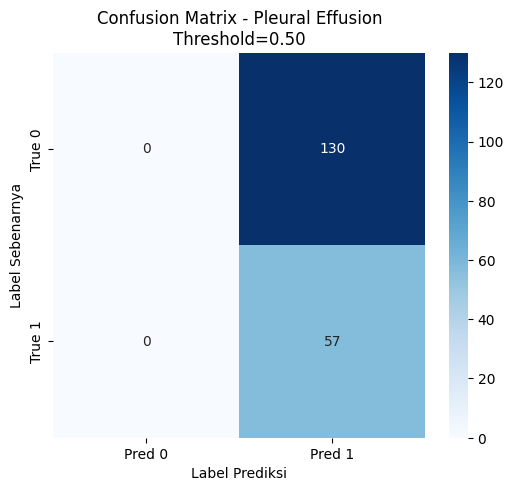

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       130
     Positif       0.30      1.00      0.47        57

    accuracy                           0.30       187
   macro avg       0.15      0.50      0.23       187
weighted avg       0.09      0.30      0.14       187

Detail Metrik:
- Sensitivity/Recall: 1.0000
- Specificity: 0.0000
- Precision: 0.3048
- F1-Score: 0.4672

ANALISIS UNTUK LABEL: FRACTURE


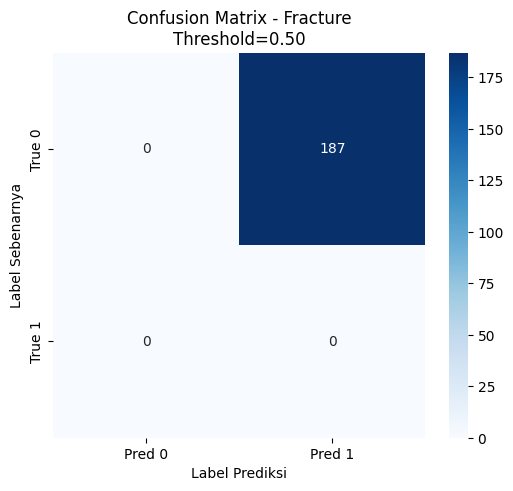

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00     187.0
     Positif       0.00      0.00      0.00       0.0

    accuracy                           0.00     187.0
   macro avg       0.00      0.00      0.00     187.0
weighted avg       0.00      0.00      0.00     187.0

Detail Metrik:
- Sensitivity/Recall: 0.0000
- Specificity: 0.0000
- Precision: 0.0000
- F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklea

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix_per_label(all_true_labels, all_probabilities, id2label, threshold=0.5):
    """
    Membuat confusion matrix dan laporan klasifikasi untuk setiap label.
    
    Args:
        all_true_labels: Tensor 2D (n_samples, n_labels) - label sebenarnya
        all_probabilities: Tensor 2D (n_samples, n_labels) - probabilitas prediksi
        id2label: Dictionary mapping id ke nama label
        threshold: Nilai ambang untuk konversi probabilitas ke prediksi biner
    """
    # Konversi ke numpy array di CPU
    y_true = all_true_labels.cpu().numpy()
    y_pred = (all_probabilities.cpu().numpy() > threshold).astype(int)
    
    n_labels = y_true.shape[1]
    
    for i in range(n_labels):
        label_name = id2label[i]
        print(f"\n{'='*50}")
        print(f"ANALISIS UNTUK LABEL: {label_name.upper()}")
        print(f"{'='*50}")
        
        # Hitung confusion matrix
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        
        # Visualisasi
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Pred 0', 'Pred 1'], 
                    yticklabels=['True 0', 'True 1'])
        plt.title(f'Confusion Matrix - {label_name}\nThreshold={threshold:.2f}')
        plt.ylabel('Label Sebenarnya')
        plt.xlabel('Label Prediksi')
        plt.show()
        
        # Laporan klasifikasi
        print(classification_report(y_true[:, i], y_pred[:, i], 
                                    target_names=['Negatif', 'Positif']))
        
        # Hitung metrik tambahan
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"Detail Metrik:")
        print(f"- Sensitivity/Recall: {sensitivity:.4f}")
        print(f"- Specificity: {specificity:.4f}")
        print(f"- Precision: {tp / (tp + fp):.4f}" if (tp + fp) > 0 else "- Precision: 0")
        print(f"- F1-Score: {2*tp / (2*tp + fp + fn):.4f}" if (2*tp + fp + fn) > 0 else "- F1-Score: 0")

# Contoh penggunaan
plot_confusion_matrix_per_label(
    all_true_labels=all_true_labels,
    all_probabilities=all_probabilities,
    id2label=model.config.id2label,
    threshold=0.5 
)